In [26]:
import pandas as pd
import matplotlib.pyplot as plt
import re
import numpy as np
import torch


poison_per_category = 100
poisoners = ['desk', 'palace', 'necklace', 'balloon', 'pillow', 
             'candle', 'pizza', 'umbrella', 'television', "baseball", 
             "ice cream", "suit", 'mountain', 'beach', 'plate',
             'orange']
full_poison_range = poison_per_category * len(poisoners)

def plot_poison_distribution(file_path, poison_category='full', filter_ratios=[0.1, 0.15, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7]):
    # df = pd.read_csv(file_path, sep='\t', header=None)
    t = torch.load(file_path).cpu().numpy()
    df = pd.DataFrame(t, columns=None)
    mean_similarity = df[1].mean()
    orig_len = len(df)

    if poison_category == 'full':
        condition = df[0] > 100000
    elif poison_category == 'less':
        condition = df[0] < (full_poison_range // 2)
    else:
        condition = (df[0] >= poison_per_category * poisoners.index(poison_category) \
                        and df[0] < poison_per_category * (poisoners.index(poison_category)+1))
    df = df[condition]
    
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(8, 6))

    n, bins, patches = ax1.hist(df.index.tolist(), bins=50, color='blue', alpha=0.5)
    ax1.xaxis.set_major_locator(plt.MaxNLocator(integer=True))
    ax1.set_title('Poison Rank Distribution')
    ax1.set_xlabel('Poison Rank')
    ax1.set_ylabel('Frequency')
    
    comments = []
    for ratio in filter_ratios:
        unfiltered_poison_num = (df.index < orig_len * ratio).sum()
        comments.append('poison num at top %f: %d'%(ratio, unfiltered_poison_num))
    comment_x = np.argmax(n)
    comment_y = np.max(n) 
    ax1.text(comment_x, comment_y, '\n'.join(comments), fontsize=12, ha='center')


    ax2.hist(df[1].tolist(), bins=30, color='green', alpha=0.5)
    ax2.invert_xaxis()
    ax2.set_title('Poison Similarity Distribution')
    ax2.set_xlabel('Poison Similarity')
    ax2.set_ylabel('Frequency')
    ax2.axvline(mean_similarity, color='red', linestyle='--', label='mean_similarity')
    ax2.legend()

    plt.tight_layout()
    plt.savefig('post_pretraining_analysis/dist_%s_%s.png' \
                %(re.search(r"/([^/]+).pt", file_path).group(1), poison_category))
    plt.close()

In [5]:
# for i in [7,12,17,22,27]:
plot_poison_distribution("/home/hyang/NNCLIP/CyCLIP/indices/nnclip_ablation_baseline_update17.pt")

In [6]:
t = torch.load("/home/hyang/NNCLIP/CyCLIP/indices/nnclip_ablation_baseline_update22.pt").cpu().numpy()
df = pd.DataFrame(t, columns=None)
mean_similarity = df[1].mean()
orig_len = len(df)
condition = df[0] > 100000
df = df[condition]

In [17]:
a = df[df.index < orig_len * 0.1][0].tolist()

In [18]:
np.sort(a)

array([100033., 100159., 100171., 100300., 100307., 100314., 100315.,
       100325., 100329., 100398., 100403.])

In [3]:
import pandas as pd
import matplotlib.pyplot as plt
import re
import numpy as np
import torch
from scipy.interpolate import make_interp_spline
from matplotlib.lines import Line2D  # I

In [2]:
def plot_clean_n_poison_similarity_distribution(file_path, poison_category='full'):
    if file_path[-2:] == 'pt':
        # import pdb
        # pdb.set_trace()
        t = torch.load(file_path).cpu().numpy()
        df = pd.DataFrame(t, columns=None)
    else:
        df = pd.read_csv(file_path, sep='\t', header=None)

    if poison_category == 'full':
        poison_condition = df[0] < full_poison_range
        clean_condition = df[0] >= full_poison_range
    elif poison_category == 'less':
        poison_condition = df[0] < (full_poison_range // 2)
        clean_condition = df[0] >= (full_poison_range // 2)
    else:
        condition = (df[0] >= poison_per_category * poisoners.index(poison_category) \
                        and df[0] < poison_per_category * (poisoners.index(poison_category)+1))
    df_poison = df[poison_condition]
    df_clean = df[clean_condition]
    
    fig, ax = plt.subplots(figsize=(8, 6))

    
    # n, bins, patches =  plt.hist(df_poison[1].tolist(), bins=30, color='blue', alpha=0.5)
    n, bins = np.histogram(df_poison[1].tolist(), bins=20, density=True)
    # n = n / n.max() * 1.1
    # Compute the midpoints of each bin
    bin_centers = 0.5 * (bins[:-1] + bins[1:])

    x_smooth = np.linspace(bin_centers.min(), bin_centers.max(), 100)  # Generate more points for a smoother curve
    y_smooth = make_interp_spline(bin_centers, n)(x_smooth)

    # Plot the smoothed curve
    # plt.plot(x_smooth, y_smooth, 'b-', linewidth=2)
    plt.fill_between(x_smooth, 0, y_smooth, alpha=0.3, color='blue')

    # n, bins, patches =  plt.hist(df_clean[1].tolist(), bins=30, color='green', alpha=0.5)
    n, bins = np.histogram(df_clean[1].tolist(), bins=30, density=True)
    # n = n / n.max() * 1.1
    # Compute the midpoints of each bin
    bin_centers = 0.5 * (bins[:-1] + bins[1:])
    
    x_smooth = np.linspace(bin_centers.min(), bin_centers.max(), 100)  # Generate more points for a smoother curve
    y_smooth = make_interp_spline(bin_centers, n)(x_smooth)

    # Plot the smoothed curve
    # plt.plot(x_smooth, y_smooth, 'g-', linewidth=2)
    
    plt.fill_between(x_smooth, 0, y_smooth, alpha=0.3, color='green')
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    
    ax.set_ylabel('Probability Density', fontsize=14)  
    ax.set_xlabel('Cosine Similarity', fontsize=14) 
    # Create custom legend entries with colored boxes
    legend_elements = [
        Line2D([0], [0], color='blue', lw=10, alpha=0.3, label='Poison'),
        Line2D([0], [0], color='green', lw=10, alpha=0.3, label='Clean'),
    ]

    # Add legend with custom entries
    ax.legend(handles=legend_elements, handlelength=4, handleheight=3, fontsize=12)

    plt.tight_layout()

    if file_path[-2:] == 'pt':
        plt.savefig('post_pretraining_analysis/clean_poison_dist_%s_%s.png' \
                %(re.search(r"/([^/]+).pt", file_path).group(1), poison_category))
    else:
        plt.savefig('post_pretraining_analysis/clean_poison_dist_%s_%s.png' \
            %(re.search(r"/([^/]+).tsv", file_path).group(1), poison_category))
    plt.close()

In [3]:
from sklearn.mixture import GaussianMixture
gmm = GaussianMixture(n_components=2, random_state=0,warm_start=False)

def fit_gmm_to_cos_sim(gmm, cos_sim):
    """
    Fits a Gaussian Mixture Model to the given loss values.

    Args:
    cos_sim (np.array): An array of loss values.
    n_components (int): The number of components for GMM. Default is 2.

    Returns:
    GaussianMixture: The fitted GMM model.
    np.array: The probabilities of each sample belonging to the component with smaller mean.
    """
    # Reshape cos_sim for GMM compatibility
    cos_sim = np.array(cos_sim).reshape(-1, 1)

    # Fit the GMM
    
    gmm.fit(cos_sim)

    # Predict probabilities
    probabilities = gmm.predict_proba(cos_sim)

    # Identify the component with the smaller mean
    larger_mean_index = np.argmax(gmm.means_)
    smaller_mean_index = np.argmin(gmm.means_)

    # Return the GMM model and probabilities of belonging to the component with smaller mean
    return gmm, probabilities[:, larger_mean_index], probabilities[:, smaller_mean_index]

In [4]:
import torch
import numpy as np
for i in [17]:
    epoch = i
    res = torch.load("/home/hyang/NNCLIP/CyCLIP/indices/SafeCLIP_CC1M_poison_no_inmodal_update{}.pt".format(epoch))
    cos_sim_threshold = 0.15 + (17-6) * 0.01
    gmm_threshold = 0.2138
    cos_sim = res.T[1].cpu().numpy()
    index = res.T[0]
    gmm_model, clean_probabilities, poisoned_probabilities = fit_gmm_to_cos_sim(gmm, cos_sim)

    clean_mean = np.max(gmm.means_)
    # print("GMM Means:", gmm_model.means_)
    # print("Clean Probabilities:", clean_probabilities)
    dirty_idx = (res.T[0] <= 8000)
    clean_idx = (res.T[0] > 8000)
    gmm_sorted_indices = torch.argsort(torch.tensor(clean_probabilities), descending=True)
    gmm_indices = index[gmm_sorted_indices]
    # new_weights = torch.tensor([0 if i < 0.9 else i for i in clean_probabilities])
    # print((new_weights[dirty_idx] > 0).sum())
    # print((new_weights[clean_idx] > 0).sum() / len(new_weights))
    selected_by_threshold = index[:int(cos_sim_threshold * len(index))]
    selected_by_gmm_threshold = gmm_indices[:int(gmm_threshold * len(index))]
    print((selected_by_threshold <= 8000).sum())
    print((selected_by_gmm_threshold <= 8000).sum())
    # train_index = new_weights.nonzero().T
    # train.append(index[train_index])
    # clean_proportion = ((new_weights[clean_idx] > 0).sum() / len(new_weights))
    # poisoned_proportion = ((new_weights[dirty_idx] > 0).sum() / len(new_weights[dirty_idx]))
    # clean.append(clean_proportion)
    # poison.append(poisoned_proportion)
    # meang.append(clean_mean)

    # new_weights_stronger = torch.tensor([0 if i < 0.8 else i for i in clean_probabilities])

    # poisoner.append((new_weights_stronger[dirty_idx] > 0).sum() / len(new_weights_stronger[dirty_idx]))
    # cleaner.append((new_weights_stronger[clean_idx] > 0).sum() / len(new_weights_stronger))

    
# new_weights_stronger = torch.tensor([0 if i < 0.8 else i for i in clean_probabilities])
# print((new_weights_stronger[dirty_idx] > 0).sum() / len(new_weights_stronger[dirty_idx]))
# print((new_weights_stronger[clean_idx] > 0).sum() / len(new_weights_stronger))

# print((torch.tensor(prob) * dirty_idx.detach().cpu()).sum()/8500)
# print((torch.tensor(prob) * clean_idx.detach().cpu()).sum()/len(prob))



tensor(331, device='cuda:4')
tensor(303, device='cuda:4')


In [7]:
torch.argsort(torch.tensor(clean_probabilities))

tensor([108517, 108516, 108515,  ...,     64,     65,     66])

tensor(0.0034)

tensor(29)

tensor(163514)

In [23]:
epoch = 7
res = torch.load("/home/hyang/NNCLIP/CyCLIP/indices/SafeCLIP_1M_test_lr_threshold_update{}.pt".format(epoch))


array([ 0.3301136 ,  0.32601854,  0.32447097, ..., -0.17802529,
       -0.17989266, -0.18224648], dtype=float32)

In [22]:
poisoned_proportion * 8500

tensor(15.9981)

python -m src.main --name SafeCLIP_test --train_data ../train_vg_55.csv --validation_data ../valid_temp.csv --device_ids 6 7 --memory_bank_size 2048 --memory_bank --batch_size 256 --filter_lr 1e-4 --num_warmup_steps 1000 --distributed --distributed_init_method tcp://127.0.0.1:5431 --cross_inmodal --multimodal_warmup 0 --inmodal_warmup 0

python -m src.main --name SafeCLIP_vg_poison_no_inmodal --train_data ../train_vg_55.csv --validation_data ../valid_temp.csv --device_ids 6 7 --memory_bank_size 2048 --memory_bank --batch_size 256 --filter_lr 1e-4 --num_warmup_steps 1000 --distributed --checkpoint /home/hyang/NNCLIP/CyCLIP/logs/SafeCLIP_vg_poison/checkpoints/epoch_5.pt --distributed_init_method tcp://127.0.0.1:5431 --cross_inmodal 

python -m src.main --name SafeCLIP_coco_poison_no_inmodal --train_data ../train_vg_55.csv --validation_data ../valid_temp.csv --device_ids 6 7 --memory_bank_size 2048 --memory_bank --batch_size 256 --filter_lr 1e-4 --num_warmup_steps 1000 --distributed --checkpoint /home/hyang/NNCLIP/CyCLIP/logs/SafeCLIP_vg_poison/checkpoints/epoch_5.pt --distributed_init_method tcp://127.0.0.1:5431 --cross_inmodal 

python -m src.main --name SafeCLIP_CC1M_poison_no_inmodal --train_data ../train_1M_500_16_backdoored.csv --validation_data ../valid_temp.csv --device_ids 4 5 6 7 --memory_bank_size 21845 --memory_bank --batch_size 512 --filter_lr 5e-6 --num_warmup_steps 1000 --distributed --distributed_init_method tcp://127.0.0.1:5431 --cross_inmodal 

python -m src.main --name SafeCLIP_coco_poison_no_inmodal --train_data ../train_coco_40.csv --validation_data ../valid_temp.csv --device_ids 6 7 --memory_bank_size 2048 --memory_bank --batch_size 256 --filter_lr 1e-4 --num_warmup_steps 1000 --distributed --distributed_init_method tcp://127.0.0.1:5431 --cross_inmodal 

python -m src.main --name SafeCLIP_coco_poison --train_data ../train_coco_40.csv --validation_data ../valid_temp.csv --device_ids 6 7 --memory_bank_size 2048 --memory_bank --batch_size 256 --filter_lr 1e-4 --num_warmup_steps 1000 --distributed --distributed_init_method tcp://127.0.0.1:5431

python -m src.main --name SafeCLIP_lr_1e-4 --train_data ../train_1M_500_16_backdoored.csv --validation_data ../valid_temp.csv --device_ids 4 5 6 7 --memory_bank_size 21846 --memory_bank --batch_size 512 --filter_lr 1e-4 --distributed --distributed_init_method tcp://127.0.0.1:5431 --checkpoint /home/hyang/NNCLIP/CyCLIP/logs/SafeCLIP_CC1M_poison_no_inmodal/checkpoints/epoch_5.pt --epochs 6 --inmodal_warmup 5 --multimodal_warmup 1

python -m src.main --name SafeCLIP_lr_5e-4 --train_data ../train_1M_500_16_backdoored.csv --validation_data ../valid_temp.csv --device_ids 4 5 6 7 --memory_bank_size 21846 --memory_bank --batch_size 512 --filter_lr 5e-4 --distributed --distributed_init_method tcp://127.0.0.1:5431 --checkpoint /home/hyang/NNCLIP/CyCLIP/logs/SafeCLIP_CC1M_poison_no_inmodal/checkpoints/epoch_5.pt --epochs 6 --inmodal_warmup 5 --multimodal_warmup 1

python -m src.main --name SafeCLIP_10_warmup --train_data ../train_1M_500_16_backdoored.csv --validation_data ../valid_temp.csv --device_ids 4 5 6 7 --memory_bank_size 21846 --memory_bank --batch_size 512 --filter_lr 5e-6 --distributed --distributed_init_method tcp://127.0.0.1:5431 --checkpoint /home/hyang/NNCLIP/CyCLIP/logs/SafeCLIP_CC1M_poison_no_inmodal/checkpoints/epoch_5.pt --epochs 10 --inmodal_warmup 10 --multimodal_warmup 0

python -m src.main --name SafeCLIP_10_warmup_1 --train_data ../train_1M_500_16_backdoored.csv --validation_data ../valid_temp.csv --device_ids 4 5 6 7 --memory_bank_size 21846 --memory_bank --batch_size 512 --filter_lr 5e-6 --distributed --distributed_init_method tcp://127.0.0.1:5431 --checkpoint /home/hyang/NNCLIP/CyCLIP/logs/SafeCLIP_CC1M_poison_no_inmodal/checkpoints/epoch_1.pt --epochs 2 --inmodal_warmup 1 --multimodal_warmup 1

python -m src.main --name SafeCLIP_no_warmup --train_data ../train_1M_500_16_backdoored.csv --validation_data ../valid_temp.csv --device_ids 4 5 6 7 --memory_bank_size 21846 --memory_bank --batch_size 512 --filter_lr 5e-6 --distributed --distributed_init_method tcp://127.0.0.1:5431 --checkpoint /home/hyang/NNCLIP/CyCLIP/logs/SafeCLIP_CC1M_poison_no_inmodal/checkpoints/epoch_1.pt --epochs 1 --inmodal_warmup 0 --multimodal_warmup 1

python -m src.main --name SafeCLIP_2_warmup --train_data ../train_1M_500_16_backdoored.csv --validation_data ../valid_temp.csv --device_ids 4 5 6 7 --memory_bank_size 21846 --memory_bank --batch_size 512 --filter_lr 5e-6 --distributed --distributed_init_method tcp://127.0.0.1:5431 --checkpoint /home/hyang/NNCLIP/CyCLIP/logs/SafeCLIP_CC1M_poison_no_inmodal/checkpoints/epoch_5.pt --epochs 7 --inmodal_warmup 5 --multimodal_warmup 2

python -m src.main --name SafeCLIP_no_nn --train_data ../train_1M_500_16_backdoored.csv --validation_data ../valid_temp.csv --device_ids 4 5 6 7 --batch_size 512 --filter_lr 5e-6 --distributed --distributed_init_method tcp://127.0.0.1:5431 --checkpoint /home/hyang/NNCLIP/CyCLIP/logs/SafeCLIP_CC1M_poison_no_inmodal/checkpoints/epoch_1.pt --epochs 32

Failed
python -m src.main --name SafeCLIP_no_warmup --train_data ../train_1M_500_16_backdoored.csv --validation_data ../valid_temp.csv --device_ids 4 5 6 7 --memory_bank_size 21846 --memory_bank --batch_size 512 --filter_lr 5e-6 --distributed --distributed_init_method tcp://127.0.0.1:5431 --checkpoint /home/hyang/NNCLIP/CyCLIP/logs/SafeCLIP_CC1M_poison_no_inmodal/checkpoints/epoch_1.pt --epochs 1 --inmodal_warmup 0 --multimodal_warmup 1

python -m src.main --name SafeCLIP_2_warmup --train_data ../train_1M_500_16_backdoored.csv --validation_data ../valid_temp.csv --device_ids 4 5 6 7 --memory_bank_size 21846 --memory_bank --batch_size 512 --filter_lr 5e-6 --distributed --distributed_init_method tcp://127.0.0.1:5431 --checkpoint /home/hyang/NNCLIP/CyCLIP/logs/SafeCLIP_CC1M_poison_no_inmodal/checkpoints/epoch_5.pt --epochs 7 --inmodal_warmup 5 --multimodal_warmup 2

1 more

python -m src.main --name SafeCLIP_10_warmup_10_1 --train_data ../train_1M_500_16_backdoored.csv --validation_data ../valid_temp.csv --device_ids 4 5 --memory_bank_size 21846 --memory_bank --batch_size 256 --filter_lr 5e-6 --distributed --distributed_init_method tcp://127.0.0.1:4431 --checkpoint /home/hyang/NNCLIP/CyCLIP/logs/SafeCLIP_10_warmup/checkpoints/epoch_10.pt --epochs 1 --inmodal_warmup 9 --multimodal_warmup 1

python -m src.main --name SafeCLIP_lr_1e-4 --train_data ../train_1M_500_16_backdoored.csv --validation_data ../valid_temp.csv --device_ids 4 5 6 7 --memory_bank_size 21846 --memory_bank --batch_size 512 --filter_lr 1e-4 --distributed --distributed_init_method tcp://127.0.0.1:5431 --checkpoint /home/hyang/NNCLIP/CyCLIP/logs/SafeCLIP_CC1M_poison_no_inmodal/checkpoints/epoch_5.pt --epochs 6 --inmodal_warmup 5 --multimodal_warmup 1

python -m src.main --name SafeCLIP_lr_5e-4 --train_data ../train_1M_500_16_backdoored.csv --validation_data ../valid_temp.csv --device_ids 4 5 6 7 --memory_bank_size 21846 --memory_bank --batch_size 512 --filter_lr 5e-4 --distributed --distributed_init_method tcp://127.0.0.1:5431 --checkpoint /home/hyang/NNCLIP/CyCLIP/logs/SafeCLIP_CC1M_poison_no_inmodal/checkpoints/epoch_5.pt --epochs 6 --inmodal_warmup 5 --multimodal_warmup 1

python -m src.main --name test --train_data ../valid.csv --validation_data ../valid_temp.csv --device_id 4 --batch_size 1 --epochs 1 --inmodal_warmup 0 --multimodal_warmup 0

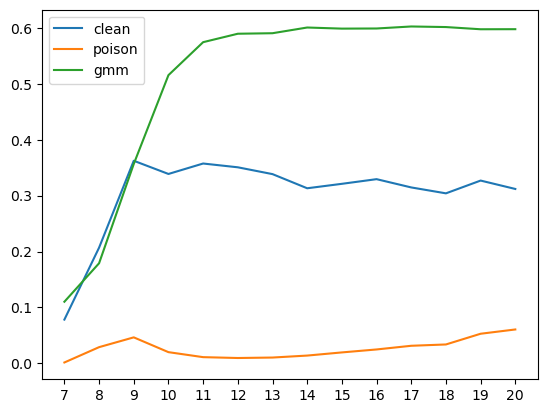

In [44]:
import matplotlib.pyplot as plt

plt.plot(list(range(7,21)), clean, label = "clean")
plt.plot(list(range(7,21)), poison, label = "poison")
# plt.plot(list(range(7,21)), cleaner, label = "cleaner")
# plt.plot(list(range(7,21)), poisoner, label = "poisoner")
plt.plot(list(range(7,21)), meang, label = "gmm")
plt.legend()
plt.xticks(list(range(7,21)))
plt.show()

In [45]:
train

[tensor([[   247,    248,    249,  ..., 315366, 315367, 315368]]),
 tensor([[    0,     1,     2,  ..., 78922, 78923, 78924]]),
 tensor([[     0,      1,      2,  ..., 208973, 208974, 208975]]),
 tensor([[     1,      2,      3,  ..., 365873, 365874, 365875]]),
 tensor([[   594,    595,    596,  ..., 342417, 342418, 342419]]),
 tensor([[   706,    707,    708,  ..., 361300, 361301, 361302]]),
 tensor([[   231,    232,    233,  ..., 353989, 353990, 353991]]),
 tensor([[   424,    425,    426,  ..., 341892, 341893, 341894]]),
 tensor([[   268,    269,    270,  ..., 316237, 316238, 316239]]),
 tensor([[   607,    608,    609,  ..., 324644, 324645, 324646]]),
 tensor([[   231,    232,    233,  ..., 332719, 332720, 332721]]),
 tensor([[   239,    240,    241,  ..., 317855, 317856, 317857]]),
 tensor([[   199,    200,    201,  ..., 307177, 307178, 307179]]),
 tensor([[    71,     72,     73,  ..., 330260, 330261, 330262]])]

In [ ]:
new_weights = torch.tensor([0 if i < 0.8 else i for i in clean_probabilities])

print((new_weights[dirty_idx] > 0).sum() / len(new_weights[dirty_idx]))
print((new_weights[clean_idx] > 0).sum() / len(new_weights))

tensor(0.0265)
tensor(0.4544)


In [ ]:
(new_weights[dirty_idx] > 0).sum()

tensor(225)

In [ ]:
print((new_weights[clean_idx] > 0).sum())

tensor(458289)


In [150]:
from scipy.stats import norm
import matplotlib.pyplot as plt
from sklearn.mixture import GaussianMixture
import numpy as np
epoch = 7
res = torch.load("/home/hyang/NNCLIP/CyCLIP/indices/SafeCLIP_lr_coco_warped_blended_update{}.pt".format(epoch))
cos_sim_threshold = 0.15
cos_sim = res.T[1].cpu()
index = res.T[0].cpu()
selected_by_threshold = index[:int(cos_sim_threshold * len(index))]
# gmm = GaussianMixture(n_components=1, random_state=0) 

# spice = int(len(cos_sim)*0.5)
# cos_sim = cos_sim[:spice]
# index = index[:spice]
# dirty_idx = (index <= 8500)
# clean_idx = (index > 8500)
# cos_sim = np.array(cos_sim).reshape(-1, 1)
# gmm.fit(cos_sim)
# print((index<= 8500).sum())
# print((index> 8500).sum())

In [151]:
selected_by_threshold[selected_by_threshold < 8500].shape

torch.Size([63])

In [121]:
log_density = gmm.score_samples(cos_sim)
log_density.max()


2.2803540368364694

In [122]:
(log_density[index<= 8500] > 2).sum()

391

In [123]:
(log_density> 2).sum()

258640

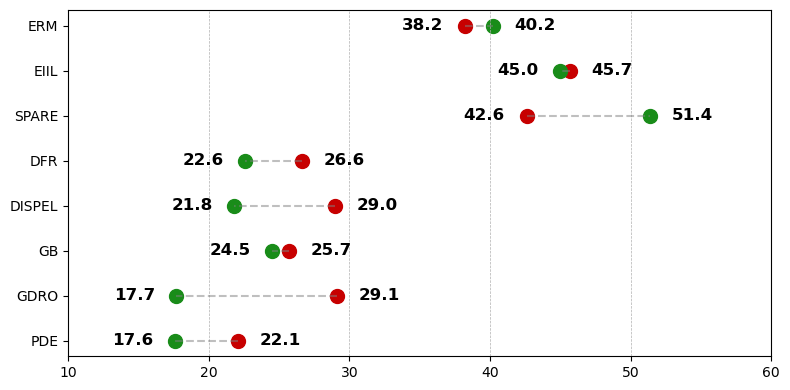

In [12]:
import matplotlib.pyplot as plt

# Data for each school
high_result = [[23.1, 61.3], [33.3, 79.0], [38.1, 80.7], [42.1, 68.7], [42.4, 71.4], [47.6, 73.3], [48.0, 77.1], [51.6, 73.7]]
method_names_reordered = ["ERM", "EIIL", "SPARE", "DFR", "DISPEL", "GB", "GDRO", "PDE"]
low_result = [[17.9, 58.1], [25.8, 70.8], [30.6, 82.0], [49.2, 71.8], [50.8, 72.6], [46.8, 71.3], [54.4, 72.1], [55.5, 73.1]]
gap_diff = [[round(x[1] - x[0], 1), round(y[1] - y[0], 1)] for x, y in zip(high_result, low_result)]

reorg_data = {}
for i, method_name in enumerate(method_names_reordered):
    reorg_data[method_name] = gap_diff[i]

# Reverse the order for display
reorg_data = {k: reorg_data[k] for k in reversed(reorg_data)}

# Define the figure and axis
fig, ax = plt.subplots(figsize=(8, 4))

# The sizes of the bubbles are assumed to be constant
bubble_size = 100

# Plotting the bubbles and the lines between them
for i, (school, percentages) in enumerate(reorg_data.items()):
    # Plot the first bubble
    mystery = 3 if percentages[0] > percentages[1] else -3
    ax.scatter(percentages[0], i, s=bubble_size, color=(199/255, 0, 0, 1))
    # Put the text below the first bubble
    ax.text(percentages[0] + mystery, i, f'{percentages[0]}', fontsize=12, horizontalalignment='center', color="black", verticalalignment='center', weight="bold")
    
    # Plot the second bubble
    ax.scatter(percentages[1], i, s=bubble_size,  color=(25/255, 140/255,25/255))
    # Put the text below the second bubble
    ax.text(percentages[1] - mystery, i, f'{percentages[1]}', fontsize=12, horizontalalignment='center', color="black", verticalalignment='center', weight="bold")
    
    # Draw a line between the bubbles
    ax.plot(percentages, [i, i], color='grey', linestyle='--', alpha=0.5)

# Set the y-axis to display school names in reversed order
ax.set_yticks(range(len(reorg_data)))
ax.set_yticklabels(list(reorg_data.keys()))
ax.set_xlim(10, 60)

# Add grid
ax.grid(True, which='major', linestyle='--', linewidth=0.5, axis='x')

# Show the plot
plt.tight_layout()
plt.show()

# Save the figure with text below bubbles
# fig.savefig("/mnt/data/tuning_single_with_text_below_reversed.pdf", bbox_inches="tight")


Impact of Unimodal CL Warmup

Impact of slow LR

In [43]:
from sklearn.mixture import GaussianMixture
gmm = GaussianMixture(n_components=2, random_state=0,warm_start=False)

def fit_gmm_to_cos_sim(gmm, cos_sim):
    """
    Fits a Gaussian Mixture Model to the given loss values.

    Args:
    cos_sim (np.array): An array of loss values.
    n_components (int): The number of components for GMM. Default is 2.

    Returns:
    GaussianMixture: The fitted GMM model.
    np.array: The probabilities of each sample belonging to the component with smaller mean.
    """
    # Reshape cos_sim for GMM compatibility
    cos_sim = np.array(cos_sim).reshape(-1, 1)

    # Fit the GMM
    
    gmm.fit(cos_sim)

    # Predict probabilities
    probabilities = gmm.predict_proba(cos_sim)

    # Identify the component with the smaller mean
    larger_mean_index = np.argmax(gmm.means_)
    smaller_mean_index = np.argmin(gmm.means_)

    # Return the GMM model and probabilities of belonging to the component with smaller mean
    return gmm, probabilities[:, larger_mean_index], probabilities[:, smaller_mean_index]

In [164]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm
# new_res=[]
# for i in [7]:
epoch = 7
res = torch.load("/home/hyang/NNCLIP/CyCLIP/indices/SafeCLIP_CC1M_poison_no_inmodal_update{}.pt".format(epoch))
# res = np.load("/home/hyang/NNCLIP/SafeCLIP_CC1M_poison_no_inmodal_all.npz")["arr_0"]
filter_ratio = 0.10 + 0.01 * (epoch - 7)
# cos_sim = res[0]
# index = np.array(list(range(len(cos_sim))))
cos_sim = res.T[1].cpu()
index = res.T[0]
# poison_num = 320

gmm_model, clean_probabilities, _ = fit_gmm_to_cos_sim(gmm, cos_sim)
weights = gmm_model.weights_
means = gmm_model.means_.flatten()
covars = gmm_model.covariances_.flatten()

dirty_idx = (res.T[0] < 8000)
clean_idx = (res.T[0] >= 8000)
    # gmm_sorted_indices = torch.argsort(torch.tensor(clean_probabilities), descending=True)
    # gmm_indices = index[gmm_sorted_indices]
    # for k in [.5, .7,.9, .95]:
new_weights = torch.tensor([0 if i < 0.9 else i for i in clean_probabilities])
multimodal_indices = index[(new_weights > 0)]
        # inmodal_indices = index[(new_weights <= 0)]

        # multimodal_indices = index[:int(len(index)*filter_ratio)]
        # inmodal_indices_30 = gmm_indices[int(len(index)*filter_ratio):]
        # res = (multimodal_indices > (len(cos_sim) - 320)).sum() / len(multimodal_indices)
        # res = (multimodal_indices <8000).sum() / len(multimodal_indices)
        # print(res)
        # print("size: {}".format(len(multimodal_indices)/len(cos_sim)) )
    # new_res.append(res.cpu())
    # print((multimodal_indices_30 <= 8000).sum() / 8000)
idx = np.argmax(means)

In [156]:
idx

1

In [125]:
cos_sim[multimodal_indices.cpu().numpy()].mean()

tensor(0.1151)

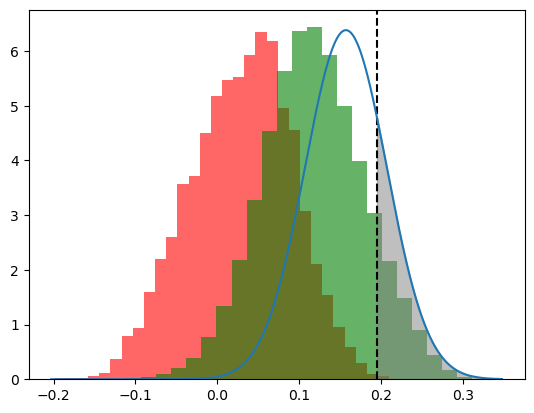

In [151]:
plt.hist(cos_sim[dirty_idx], bins=30, density=True, alpha=0.6, color='r')
plt.hist(cos_sim[clean_idx], bins=30, density=True, alpha=0.6, color='g')
# plt.hist(cos_sim[multimodal_indices.cpu().numpy()], bins=30, density=True, alpha=0.6, color='b')
x = np.linspace(cos_sim.min(), cos_sim.max(), 1000)
plt.axvline(x=0.195, color='k', linestyle='--')
# Scale the PDF by the number of samples and the bin width
pdf = 0.8 * norm.pdf(x, means[idx], np.sqrt(covars[idx])) * 1.
plt.fill_between(x, pdf, where=(x >= 0.195), color='grey', alpha=0.5)
plt.plot(x, pdf)



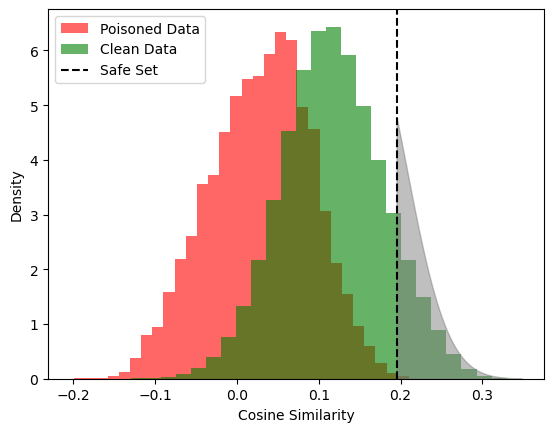

In [161]:
# Let's beautify the plot with clear labels, an outstanding GMM line, and a legend.

# Define the figure and axis
fig, ax = plt.subplots()

# Plot the histograms for dirty (poisoned) and clean data
ax.hist(cos_sim[dirty_idx], bins=30, density=True, alpha=0.6, color='r', label='Poisoned Data')
ax.hist(cos_sim[clean_idx], bins=30, density=True, alpha=0.6, color='g', label='Clean Data')

# Generate x values for the GMM PDF plot
x = np.linspace(cos_sim.min(), cos_sim.max(), 1000)

# Calculate the PDF values
pdf = 0.8 * norm.pdf(x, means[idx], np.sqrt(covars[idx]))

# Plot the GMM PDF with a thicker line to make it more outstanding
# ax.plot(x, pdf, color='blue', linewidth=2.5, label='GMM')


# Draw a vertical line at x = 0.195 and label it
ax.axvline(x=0.195, color='k', linestyle='--', label='Safe Set')

# Shade the area to the right of x = 0.195
ax.fill_between(x, pdf, where=(x >= 0.195), color='grey', alpha=0.5)

# Add labels and title
ax.set_xlabel('Cosine Similarity')
ax.set_ylabel('Density')
# ax.set_title('Cosine Similarity Distribution with GMM')

# Add a legend
ax.legend()

# Show the plot with the new styling
plt.show()


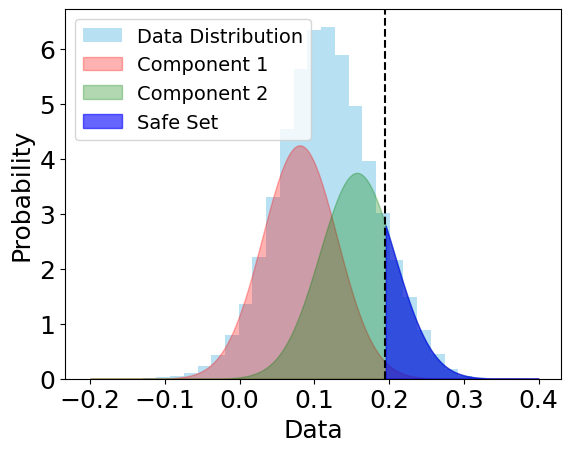

In [190]:
# Plot the data
# plt.hist(cos_sim[dirty_idx], bins=30, density=True, alpha=0.6, color='g')
# plt.hist(cos_sim[clean_idx], bins=30, density=True, alpha=0.6, color='r')
plt.hist(cos_sim, bins=30, density=True, alpha=0.6, color='skyblue', label='Data Distribution')
# Plot each Gaussian distribution
x = np.linspace(-0.2, 0.4, 500).reshape(-1, 1)
logprob = gmm.score_samples(x)
responsibilities = gmm.predict_proba(x)
pdf = np.exp(logprob)
pdf_individual = responsibilities * pdf[:, np.newaxis]
plt.axvline(x=0.195, color='k', linestyle='--')
plt.fill_between(x.flat, pdf_individual[:, 0], alpha=0.3, color='red', label='Component 1')
plt.fill_between(x.flat, pdf_individual[:, 1], alpha=0.3, color='green', label='Component 2')
plt.fill_between(x.flat, 0, pdf_individual[:, 1], where=(x.flat >= 0.195), color='blue', alpha=0.6, label='Safe Set')
plt.xlabel('Data', fontsize=18)
plt.ylabel('Probability', fontsize=18)
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
plt.legend(fontsize=14)
plt.show()

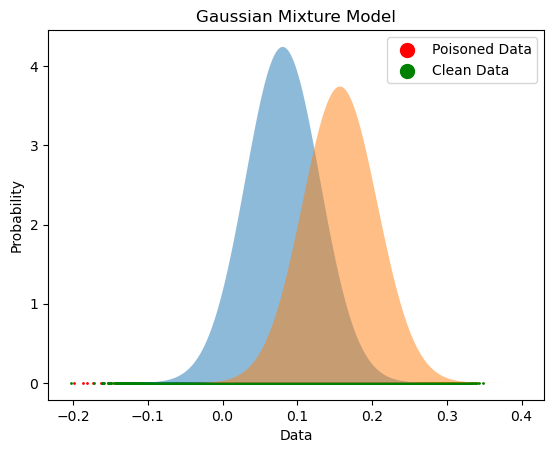

In [172]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.mixture import GaussianMixture
from scipy.stats import norm

# Assuming gmm is already fitted and these variables are defined
# cos_sim: array of cosine similarity values
# dirty_idx: boolean array or indices for "poisoned" data
# clean_idx: boolean array or indices for "clean" data

# Generate x values for the GMM PDF plot
x = np.linspace(-0.2, 0.4, 500).reshape(-1, 1)
logprob = gmm.score_samples(x)
responsibilities = gmm.predict_proba(x)
pdf = np.exp(logprob)
pdf_individual = responsibilities * pdf[:, np.newaxis]

# Create the scatter plot with different colors for clean and poisoned data
plt.scatter(cos_sim[dirty_idx], np.zeros_like(cos_sim[dirty_idx]), color='r', s=1, label='Poisoned Data')
plt.scatter(cos_sim[clean_idx], np.zeros_like(cos_sim[clean_idx]), color='g', s=1, label='Clean Data')

# Fill between the Gaussian distributions
plt.fill_between(x.flat, pdf_individual[:, 0], alpha=0.5)
plt.fill_between(x.flat, pdf_individual[:, 1], alpha=0.5)

# Set labels and title
plt.xlabel('Data')
plt.ylabel('Probability')
plt.title('Gaussian Mixture Model')

# Add legend
plt.legend(markerscale=10)  # Increase marker scale so it's visible in the legend

# Show the plot
plt.show()


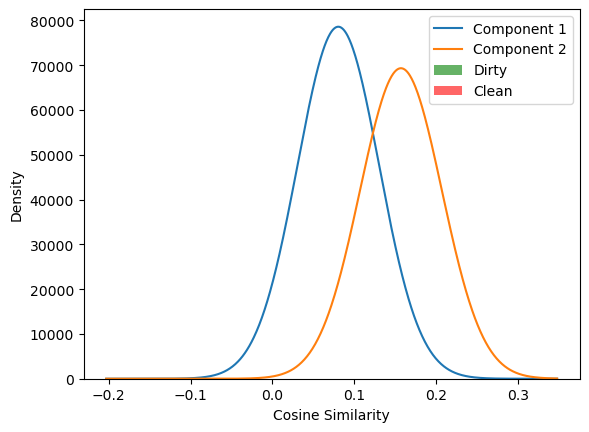

In [69]:
# import numpy as np
# import matplotlib.pyplot as plt
# from scipy.stats import norm

# # Assuming these variables are defined:
# # cos_sim, dirty_idx, clean_idx, gmm_model

# # Calculate the number of samples and the bin width
# n_samples = len(cos_sim)
# bin_width = (cos_sim.max() - cos_sim.min()) / 30

# # Calculate histograms manually
# hist_dirty, bin_edges = np.histogram(cos_sim[dirty_idx], bins=30, density=False)
# hist_clean, _ = np.histogram(cos_sim[clean_idx], bins=30, density=False)

# # Normalize the histograms to get density
# hist_dirty_density = hist_dirty / (n_samples * bin_width)
# hist_clean_density = hist_clean / (n_samples * bin_width)

# # Get the center of each bin
# bin_centers = (bin_edges[1:] + bin_edges[:-1]) / 2

# # Plot the scaled histograms
# plt.bar(bin_centers, hist_dirty_density, width=bin_width, alpha=0.6, color='g', label='Dirty')
# plt.bar(bin_centers, hist_clean_density, width=bin_width, alpha=0.6, color='r', label='Clean')

# # Plot the GMM PDFs with the same scaling
# x = np.linspace(cos_sim.min(), cos_sim.max(), 1000)
# for i in range(gmm_model.n_components):
#     # Scale the PDF by the number of samples and the bin width
#     pdf = gmm_model.weights_[i] * norm.pdf(x, gmm_model.means_[i, 0], np.sqrt(gmm_model.covariances_[i, 0]))
#     plt.plot(x, pdf * n_samples * bin_width.numpy(), label=f'Component {i+1}')

# plt.legend()
# plt.xlabel('Cosine Similarity')
# plt.ylabel('Density')
# plt.show()


IndexError: too many indices for array: array is 0-dimensional, but 1 were indexed

In [35]:
(multimodal_indices <8000).sum()

tensor(7, device='cuda:4')

CC1M
0.9: 6.0984e-05
0.8: 0.0003
0.7: 0.0005
0.6: 0.0008
0.5: 0.0010
total:0.008
COCO
0.9:0.0004
0.8:0.0012
0.7:0.0018
0.6:0.0028
0.5:0.0034
total: 0.008

VG
0.95: nan
0.9:0.0
0.8:0.0006
0.7:0.0012
0.6:0.0020
0.5:0.0030
total: 0.008

CC1M
0.9: 0.0009
0.8: 0.0068
0.7: 0.0190
0.6: 0.0358
0.5: 0.0591

COCO
0.9:0.0063
0.8:0.0437
0.7:0.1000
0.6:0.1906
0.5:0.2719

VG
0.9:0.0
0.8:0.0227
0.7:0.0659
0.6:0.1341
0.5:0.2432

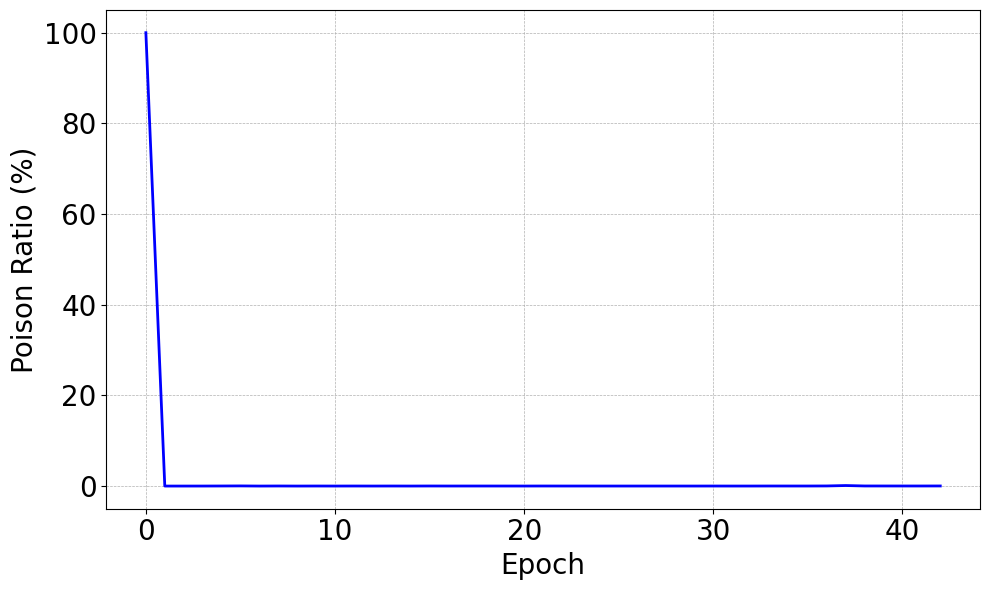

In [76]:
epochs = range(len(new_res))
poison_ratios = new_res # Decaying percentage

# Now, create the improved plot
plt.figure(figsize=(10, 6))
plt.plot(epochs, poison_ratios, 'b-', linewidth=2)

# Adding the requested labels and a title
plt.xlabel('Epoch', fontsize=20)
plt.ylabel('Poison Ratio (%)', fontsize=20)
# plt.title('Epoch vs Poison Ratio', fontsize=14)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
# Adding grid lines
plt.grid(True, which='both', linestyle='--', linewidth=0.5)

# Adding some padding to the plot layout for better presentation
plt.tight_layout()



In [55]:
int(len(index)*filter_ratio)

39509

In [56]:
filter_ratio

0.492

In [57]:
len(index)

80304

In [58]:
multimodal_indices

tensor([53405., 30013., 34167.,  ..., 13319., 75828., 27546.], device='cuda:6')

In [59]:
len(multimodal_indices) / len(res[0])

IndexError: invalid index of a 0-dim tensor. Use `tensor.item()` in Python or `tensor.item<T>()` in C++ to convert a 0-dim tensor to a number

In [ ]:
len(multimodal_indices) / len(res[0])

0.1440872583044125

In [ ]:
len(multimodal_indices) / len(res)

0.06253340459647247

vg
5e-6: 0
1e-5: 0.23
5e-05:0
1e-4: 0.23
coco
5e-6:1.82
1e-5:1.25
5e-5:0.63
1e-4:2.27

In [ ]:
len(res) - 440

108078

LR Difference

In [ ]:
lr = ["5e-6", "1e-5", "5e-5"]

remained_poison = [0.09, 0.04, 0.18]
remained_poison_30 = [2.1, 2.79, 1.96]

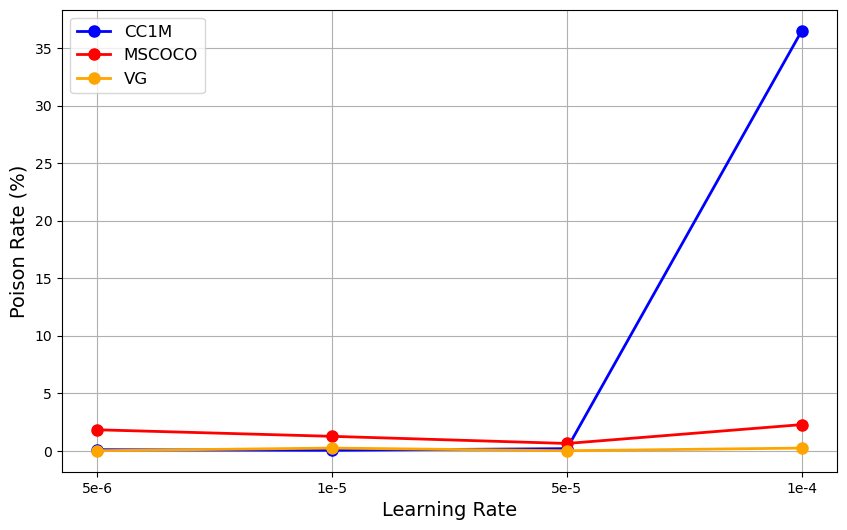

In [ ]:
import matplotlib.pyplot as plt

# Data
learning_rates = ["5e-6", "1e-5", "5e-5", "1e-4"]
cc1m_remained_poison = [0.09, 0.04, 0.18,36.5]  # Poison rate in the safe set
vg_remained_poison = [0, 0.23,0,0.23]
coco_remained_poison = [1.82, 1.25, 0.63,2.27]
# cc1m_remained_poison_30 = [2.1, 2.79, 1.96]  # Poison rate in the top 30%

# Convert string learning rates to indices for plotting
plt.figure(figsize=(10, 6))

# Plot the data
plt.plot(learning_rates, cc1m_remained_poison, 'o-', label='CC1M', color='blue', linewidth=2, markersize=8)
plt.plot(learning_rates, coco_remained_poison, 'o-', label='MSCOCO', color='red', linewidth=2, markersize=8)
plt.plot(learning_rates, vg_remained_poison, 'o-', label='VG', color='orange', linewidth=2, markersize=8)

# Add titles and labels
# plt.title('Poison Rate vs Learning Rate', fontsize=16)
plt.xlabel('Learning Rate', fontsize=14)
plt.ylabel('Poison Rate (%)', fontsize=14)

# Improve the legend
plt.legend(fontsize=12, loc='upper left')

# Add a grid for better readability
plt.grid(True)

# Show the plot
plt.show()


CLIP Warmup DIfference

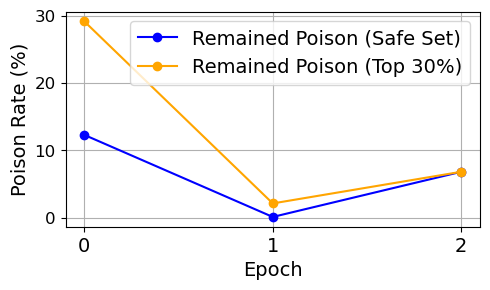

In [ ]:
import matplotlib.pyplot as plt

# Data
epochs = [0,1,2]
remained_poison = [12.28, 0.09, 6.8]  # Poison rate in the safe set
remained_poison_30 = [29.15, 2.1, 6.8]  # Poison rate in the top 30%

# Convert string learning rates to indices for plotting
x_indices = range(len(epochs))

# Plotting
fig, ax = plt.subplots(figsize=(5,3))

# Plot for remained_poison in the safe set
ax.plot(x_indices, remained_poison, '-o', label='Remained Poison (Safe Set)', color='blue')

# Plot for remained_poison_30 in the top 30%
ax.plot(x_indices, remained_poison_30, '-o', label='Remained Poison (Top 30%)', color='orange')

# Setting the x-axis to show learning rate labels
ax.set_xticks(x_indices,fontsize=14)
ax.set_xticklabels(epochs,fontsize=14)
ax.tick_params(axis='y', labelsize='large')
# Labels and Title
ax.set_xlabel('Epoch',fontsize=14)
ax.set_ylabel('Poison Rate (%)',fontsize=14)
# ax.set_title('Poison Rate at Different Learning Rates')

# Legend
ax.legend(fontsize=14)

# Show grid
ax.grid(True)
plt.tight_layout()
# Save the figure
plt.savefig('poison_rate_epoch.png')

# Show the plot
plt.show()



Unimodal Warmup Difference

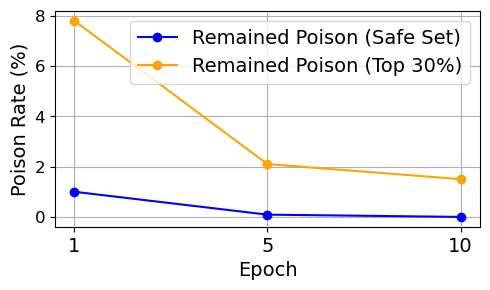

In [ ]:
import matplotlib.pyplot as plt

# Data
epochs = [1,5,10 ]
remained_poison = [1,0.09,0]  # Poison rate in the safe set
remained_poison_30 = [7.8, 2.1, 1.5]  # Poison rate in the top 30%

# Convert string learning rates to indices for plotting
x_indices = range(len(epochs))

# Plotting
fig, ax = plt.subplots(figsize=(5,3))

# Plot for remained_poison in the safe set
ax.plot(x_indices, remained_poison, '-o', label='Remained Poison (Safe Set)', color='blue')

# Plot for remained_poison_30 in the top 30%
ax.plot(x_indices, remained_poison_30, '-o', label='Remained Poison (Top 30%)', color='orange')

# Setting the x-axis to show learning rate labels
ax.set_xticks(x_indices,fontsize=14)
ax.set_xticklabels(epochs,fontsize=14)
ax.tick_params(axis='y', labelsize='large')
# Labels and Title
ax.set_xlabel('Epoch',fontsize=14)
ax.set_ylabel('Poison Rate (%)',fontsize=14)
# ax.set_title('Poison Rate at Different Learning Rates')

# Legend
ax.legend(fontsize=14)

# Show grid
ax.grid(True)
plt.tight_layout()
# Save the figure
plt.savefig('poison_rate_unimodal_epoch.png')
# Show the plot
plt.show()


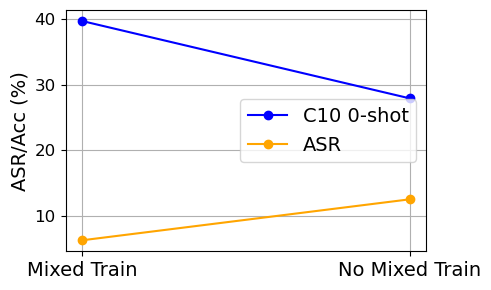

In [ ]:
import matplotlib.pyplot as plt

# Data
x_axis = ["Mixed Train", "No Mixed Train"]
performance = [39.7, 27.9]
asr = [6.25, 12.5]

# Convert string learning rates to indices for plotting
x_indices = range(len(x_axis))

# Plotting
fig, ax = plt.subplots(figsize=(5,3))

# Plot for remained_poison in the safe set
ax.plot(x_indices, performance, '-o', label='C10 0-shot', color='blue')

# Plot for remained_poison_30 in the top 30%
ax.plot(x_indices, asr, '-o', label='ASR', color='orange')

# Setting the x-axis to show learning rate labels
ax.set_xticks(x_indices,fontsize=14)
ax.set_xticklabels(x_axis,fontsize=14)
ax.tick_params(axis='y', labelsize='large')
# Labels and Title
# ax.set_xlabel('Epoch')
ax.set_ylabel('ASR/Acc (%)',fontsize=14)
# ax.set_title('Poison Rate at Different Learning Rates')

# Legend
ax.legend(fontsize=14)

# Show grid
ax.grid(True)
plt.tight_layout()
# Save the figure
plt.savefig('mixed_train.png')

# Show the plot
plt.show()


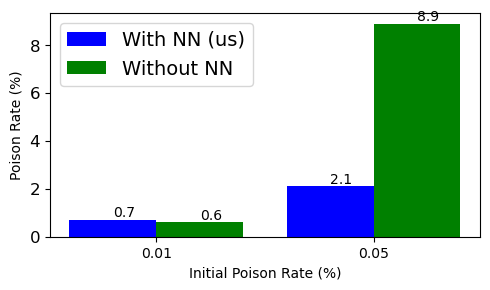

In [ ]:
# Code to recreate a bar plot similar to the one in the provided image

# Importing necessary library
import matplotlib.pyplot as plt

# Data
initial_dpr = [0.01, 0.05]  # x-axis
post_warmup_dpr_with_nn = [0.7, 2.1]  # y-axis values for 'With NN (us)'
post_warmup_dpr_without_nn = [0.6, 8.9]  # y-axis values for 'Without NN'

# Correcting the bar positions so that the corresponding 'With NN (us)' and 'Without NN' bars are grouped together

# Define the figure and axis
fig, ax = plt.subplots(figsize=(5, 3))

# Set the positions for the groups and the width of each bar
group_positions = [1, 2]
bar_width = 0.4

# Calculate positions for the 'With NN (us)' and 'Without NN' bars
positions_with_nn = [x - bar_width/2 for x in group_positions]
positions_without_nn = [x + bar_width/2 for x in group_positions]

# Plot the 'With NN (us)' bars
with_nn_bars = ax.bar(positions_with_nn, post_warmup_dpr_with_nn, bar_width, label='With NN (us)', color='blue')

# Plot the 'Without NN' bars
without_nn_bars = ax.bar(positions_without_nn, post_warmup_dpr_without_nn, bar_width, label='Without NN', color='green')

# Adding the data labels on the bars
for bar in with_nn_bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2.0, yval, round(yval, 1), va='bottom')  # va: vertical alignment

for bar in without_nn_bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2.0, yval, round(yval, 1), va='bottom')

# Set the X-axis labels
ax.set_xticks(group_positions)
ax.set_xticklabels(['0.01', '0.05'])
ax.set_xlabel('Initial Poison Rate (%)')
ax.tick_params(axis='y', labelsize='large')
# Set the Y-axis label
ax.set_ylabel('Poison Rate (%)')

# Add the legend
ax.legend(fontsize=14)
plt.tight_layout()
plt.savefig('nn.png')
# Show the plot
plt.show()

